In [ ]:
# importing libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Conv2D, Dropout, Conv2DTranspose, MaxPool2D, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
import glob
from keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow # for image display
import os

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# YCrCb range for extracting skin color
min_YCrCb = np.array([0,133,77],np.uint8)
max_YCrCb = np.array([235,173,127],np.uint8)
 
# HSV range for extracting skin color
lower = np.array([0, 10, 60], dtype = "uint8") 
upper = np.array([20, 150, 255], dtype = "uint8")

# kernel for morphological operations
kernel = np.ones((3,3),np.uint8)

# Load and split  dataset

In [ ]:
# loading dataset from drive
!unzip '/content/drive/MyDrive/sign_final.zip'

In [ ]:
!pip install split-folders

In [ ]:
# splitting dataset into 70% training and 30% testing data
import splitfolders
splitfolders.ratio('/content/Sign-Language-Digits-Dataset-master/Dataset', output='out', ratio=(0.7,0.3))

Copying files: 2062 files [00:00, 8976.57 files/s]


In [ ]:
# path of training and test data
train_path = 'out/train/'
test_path = 'out/val/'

#Performing operations on couple of images before applying them to whole dataset

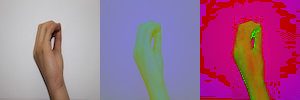

In [ ]:
#original image
img = cv2.imread('/content/out/train/0/IMG_1138.JPG')

# HSV image
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

# YCrCb image
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)

frame = cv2.hconcat((img,img2,img1))
cv2_imshow(frame)

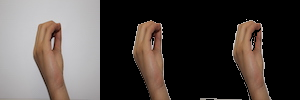

In [ ]:
# masking YCrCb image
mask = cv2.inRange(img2,min_YCrCb,max_YCrCb)
masked_img01 = cv2.bitwise_and(img, img, mask = mask)

#masking hsv image
mask1 = cv2.inRange(img1,lower,upper)
masked_img02 = cv2.bitwise_and(img, img, mask = mask1)

frame  = cv2.hconcat((img, masked_img01, masked_img02))
cv2_imshow(frame)

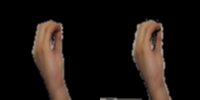

In [ ]:
# smoothing YCrCb masked image
gaus_img = cv2.GaussianBlur(masked_img01,(3,3),0)
# smoothing hsv masked image
gaus_img1 = cv2.GaussianBlur(masked_img02,(3,3),0)

frame3 = cv2.hconcat((gaus_img,gaus_img1))
cv2_imshow(frame3)

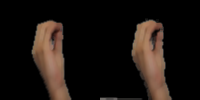

In [ ]:
# morphological opening transformations 

#YCrCb input
img1 = cv2.morphologyEx(gaus_img, cv2.MORPH_OPEN, kernel)

#HSV input
img2 = cv2.morphologyEx(gaus_img1, cv2.MORPH_OPEN, kernel)
frame3 = cv2.hconcat((img1,img2))
cv2_imshow(frame3)

In [ ]:
# importing our generated images which includes some background
!unzip '/content/drive/MyDrive/Class 1-samples.zip'

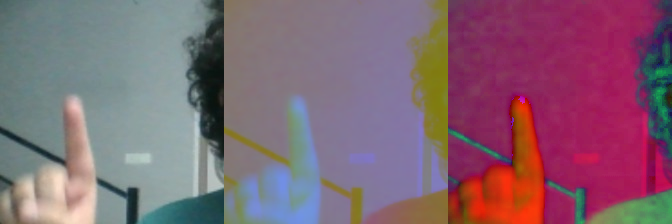

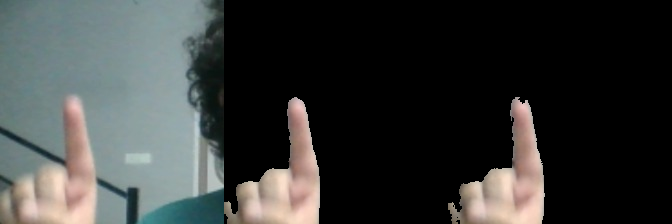

In [ ]:
img_new = cv2.imread('0.jpg')
#YcrCb
img2_new = cv2.cvtColor(img_new,cv2.COLOR_BGR2YCR_CB)
#HSV
img3_new = cv2.cvtColor(img_new,cv2.COLOR_BGR2HSV)

frame1  = cv2.hconcat((img_new, img2_new, img3_new))
cv2_imshow(frame1)

# YCrCb range for extracting skin color
min_YCrCb = np.array([0,133,77],np.uint8)
max_YCrCb = np.array([235,173,127],np.uint8)

# masking YCrCb image
mask = cv2.inRange(img2_new,min_YCrCb,max_YCrCb)
masked_img1 = cv2.bitwise_and(img_new, img_new, mask = mask)


# HSV range for extracting skin color
lower = np.array([0, 10, 60], dtype = "uint8") 
upper = np.array([20, 150, 255], dtype = "uint8")

#masking hsv image
mask1 = cv2.inRange(img3_new,lower,upper)
masked_img2 = cv2.bitwise_and(img_new, img_new, mask = mask1)

frame2  = cv2.hconcat((img_new, masked_img1, masked_img2))
cv2_imshow(frame2)

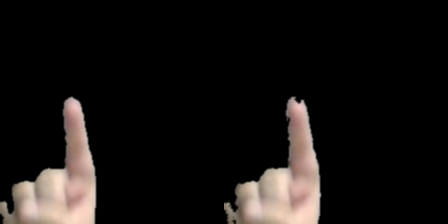

In [ ]:
# smoothing YCrCb masked image
gaus_img = cv2.GaussianBlur(masked_img1,(3,3),0)
# smoothing hsv masked image
gaus_img1 = cv2.GaussianBlur(masked_img2,(3,3),0)

frame3 = cv2.hconcat((gaus_img,gaus_img1))
cv2_imshow(frame3)

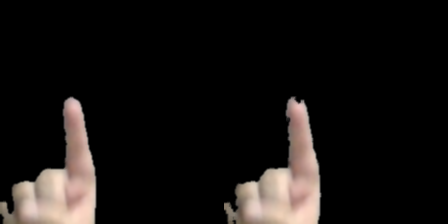

In [ ]:
# morphological opening 
img1 = cv2.morphologyEx(gaus_img, cv2.MORPH_OPEN, kernel)

img2 = cv2.morphologyEx(gaus_img1, cv2.MORPH_OPEN, kernel)
frame3 = cv2.hconcat((img1,img2))
cv2_imshow(frame3)

# image dataset training on DenseNet121 model 

From the output images above we can say that hsv masked image is noisy so we converted our images into YCrCb format

In [ ]:
# preprocessing training dataset and appending them to a list
n_class = np.eye(10) # number of class 
X = [] 
y_train = []
i=0
for category in sorted(os.listdir(train_path)):
    print('loading category: '+ category)
    for fname in os.listdir(train_path+category):
        img = cv2.imread(train_path+category+'/'+fname)
        imageYCrCb = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2YCR_CB)
        skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
        skinYCrCb = cv2.bitwise_and(img, img, mask = skinRegionYCrCb) # mask to detect skin in the image
        img = cv2.resize(skinYCrCb,(64,64))
        img = cv2.GaussianBlur(img,(3,3),0) # smoothening the masked image
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) # morphological opening to remove noise in background without affecting the shape of foreground
        y = np.reshape(n_class[i], [10]).tolist()
        y_train.append(y)
        X.append(img)
    i+=1

In [ ]:
# converting list to numpy array 
X_train = np.array(X)
y_train = np.array(y_train)

In [ ]:
#dimension of training data
X_train.shape

In [ ]:
# displaying a preprocessed image
cv2_imshow(X_train[1250])

In [ ]:
# displaying another preprocessed image for surity before training the model
cv2_imshow(X_train[1])

In [ ]:
# preprocessing testing dataset and appending them to a list
X1 = []
y_test = []
i=0
for category in sorted(os.listdir(test_path)):
    print('loading category: '+ category)
    for fname in os.listdir(test_path+category):
        img1 = cv2.imread(test_path+category+'/'+fname)
        imageYCrCb = cv2.cvtColor(img1, cv2.cv2.COLOR_BGR2YCR_CB)
        skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
        skinYCrCb = cv2.bitwise_and(img1, img1, mask = skinRegionYCrCb) # mask to detect skin in the image
        img1 = cv2.resize(skinYCrCb,(64,64))
        img1 = cv2.GaussianBlur(img1,(3,3),0) # smoothening the masked image
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) # morphological opening to remove noise in background without affecting the shape of foreground
        y = np.reshape(n_class[i], [10]).tolist()
        y_test.append(y)
        X1.append(img1)
    i+=1    
  

In [ ]:
# covert to numpy array
X_test = np.array(X1)
y_test = np.array(y_test)

In [ ]:
# test image dimensions
X_test.shape

In [ ]:
# loading densenet model with random weights and without top layers
from tensorflow.keras.applications import DenseNet121

dnet = DenseNet121(input_shape=(64,64,3), weights=None, include_top=False)

In [ ]:
# adding global average pooling layer after the loaded densenet model and finally adding a softmax layer with 10 outputs to get the probablity of the predicted category
x = GlobalAveragePooling2D()(dnet.output)
pred = Dense(10,activation='softmax')(x)
model = Model(inputs=dnet.input, outputs=pred)

filepath="trained_model_sgd_{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
stopingpoint = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="auto", baseline=None, restore_best_weights=True )
callbacks_list = [checkpoint, stopingpoint]

In [ ]:
# as the output is from 10 category so we used categorical crossentropy and sgd optimiser worked best 
model.compile(
    optimizer= 'sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
# del model

In [ ]:
# training the model
history = model.fit(
    X_train, y_train,batch_size=64,
    validation_data = (X_test, y_test),
    epochs=50,
    steps_per_epoch=len(X_train)//64,
    callbacks = callbacks_list
)

In [ ]:
# Plot training & validation accuracy values
print('Plot training & validation accuracy values\n')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
print('Plot training & validation loss values\n')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# capture image

In [ ]:
#loading saved model
model = load_model('/content/drive/MyDrive/cv/trained_model_sgd_38.h5')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename= 'photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
 
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
 
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0,);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Show hand gesture for this captcha: 4855


<IPython.core.display.Javascript object>

Saved to photo_0.jpg


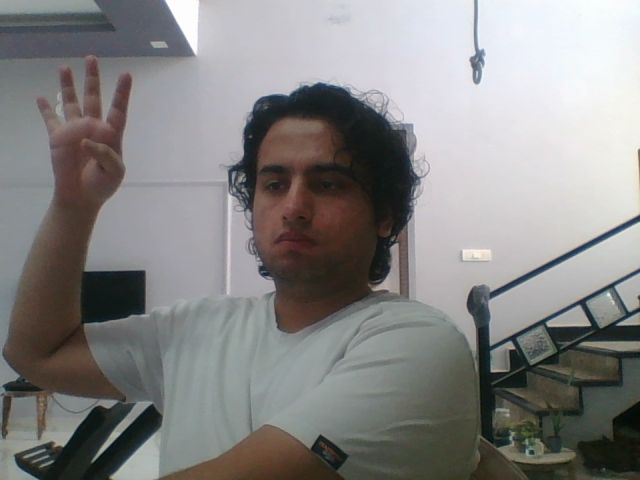

<IPython.core.display.Javascript object>

Saved to photo_1.jpg


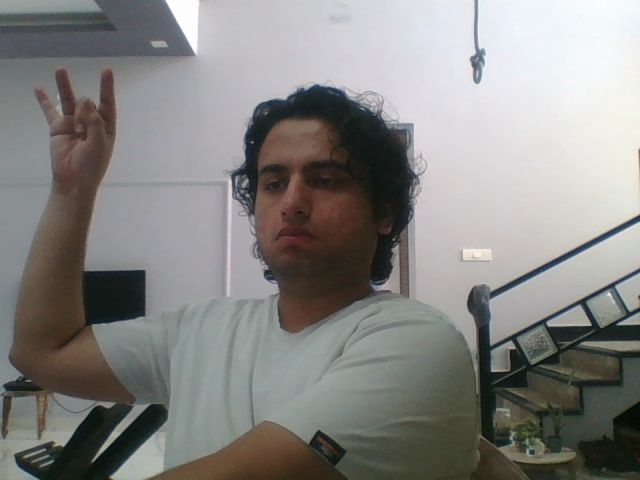

<IPython.core.display.Javascript object>

Saved to photo_2.jpg


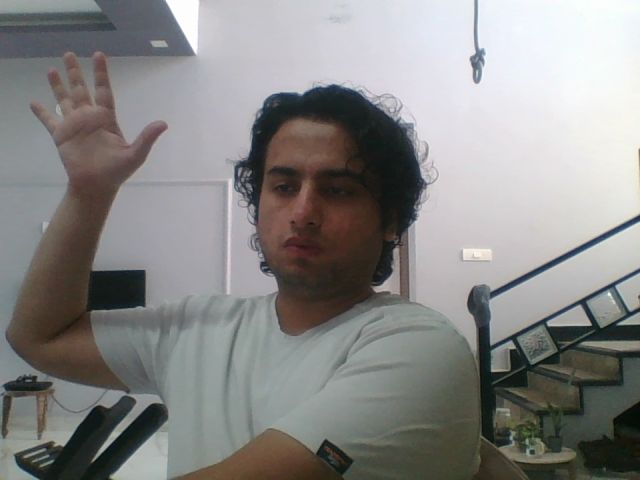

<IPython.core.display.Javascript object>

Saved to photo_3.jpg


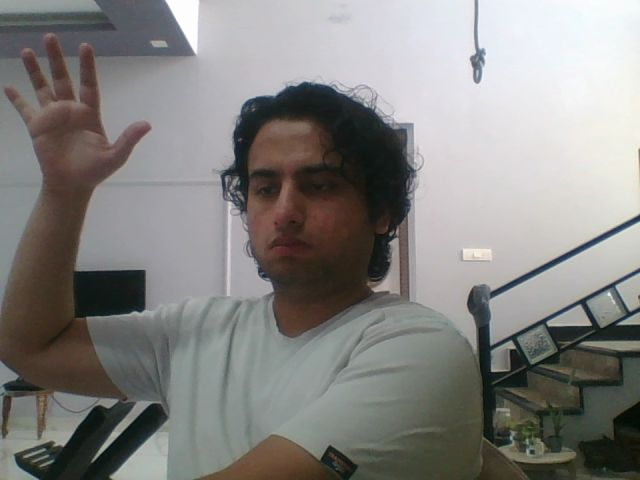

In [ ]:
from IPython.display import Image
from random import randint
i = 0
val = randint(1000,9999)
print('Show hand gesture for this captcha:', val)
for i in range(4):
  try:
    filename = take_photo(filename=f'photo_{i}.jpg')
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

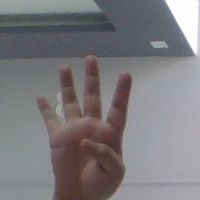

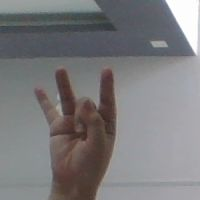

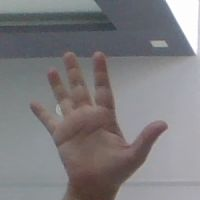

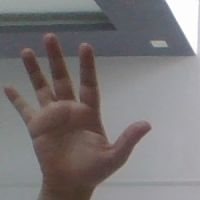

In [ ]:
X=[]
for i in range(4):
  imgX= cv2.imread(f'photo_{i}.jpg')
  imgX_crop= imgX[0:200,0:200]
  X.append(imgX_crop)
  cv2_imshow(imgX_crop)

In [ ]:
 y = []
#for i in range(4):
for i in X:
  #img1 = cv2.imread(f'photo_{i}.jpg')
  img1=i
  imageYCrCb = cv2.cvtColor(img1, cv2.cv2.COLOR_BGR2YCR_CB)
  skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
  skinYCrCb = cv2.bitwise_and(img1, img1, mask = skinRegionYCrCb)
  img1 = cv2.resize(skinYCrCb,(64,64))
  img1 = cv2.GaussianBlur(img1,(3,3),0)
  img1 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, kernel)
  final_image = np.expand_dims(img1, axis=0)
  y_pred = model.predict(final_image)
  y.append(y_pred.argmax())


In [ ]:
y

[4, 8, 5, 5]

In [ ]:
y_str = ''.join(map(str, y))

In [ ]:
if y_str == str(val):
  print('Success!, you are not a robot.')
else:
  print('Wrong Answer. try again.')

Success!, you are not a robot.


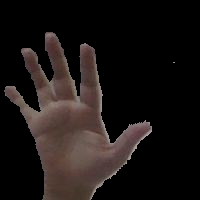

In [ ]:
cv2_imshow(skinYCrCb)

#demo

In [ ]:
#loading saved model
model = load_model('/content/drive/MyDrive/cv/trained_model_sgd_38.h5')

In [ ]:
from random import randint

val = randint(1000,9999)
display(HTML('''
<style>
#captcha{
  width:100px;
  height:50px;
  border: 2px solid #00f;
  background: #fff;
  padding:20px;
  
  }
</style>
<div id='captcha'> 
<h3 id='num'></h3></div>
<script>
function myFunction() {
  var val = Math.floor(Math.random()*9000) + 1000;
  document.getElementById("num").innerHTML = val;
  return val;
}
</script>
 '''))
rand = eval_js('myFunction()')

In [ ]:
rand

5671

In [ ]:
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename= 'photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const sub_div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      const canvas_rect = document.createElement('canvas');
      
      canvas_rect.style.position ='relative';
      canvas_rect.style.border ='2px solid #00ff00';
      canvas_rect.style.width ='200px';
      canvas_rect.style.height ='200px';
      canvas_rect.style.top ='210px';

  
      video.style.display = 'block';
    
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(sub_div);
      document.body.appendChild(div);
      sub_div.appendChild(canvas_rect);
      sub_div.appendChild(video);

      
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      canvas_rect.hidden = true;
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0,);
      stream.getVideoTracks()[0].stop();
      div.remove();
      sub_div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
from random import randint
i = 0
# val = randint(1000,9999)
y=[]
# print('Show hand gesture for this captcha:', val)
display(HTML('''
<style>
#captcha{
  width:100px;
  height:50px;
  border: 2px solid #00f;
  background: #fff;
  padding-left:50px;
  
  }
</style>
<div id='captcha'> 
<h2 id='num'></h2></div>
<script>
function myFunction() {
  var val = Math.floor(Math.random()*9000) + 1000;
  document.getElementById("num").innerHTML = val;
  return val;
}
</script>
 '''))
rand = eval_js('myFunction()')
for i in range(4):
  try:
    filename = take_photo(filename=f'photo_{i}.jpg')
    print('Saved to {}'.format(filename))
    # extract hand from image
    imgX= cv2.imread(f'photo_{i}.jpg')
    imgX_crop= imgX[0:200,0:200]
    cv2_imshow(imgX_crop)

    imageYCrCb = cv2.cvtColor(imgX_crop, cv2.cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
    skinYCrCb = cv2.bitwise_and(imgX_crop, imgX_crop, mask = skinRegionYCrCb)
    imgX_crop = cv2.resize(skinYCrCb,(64,64))
    imgX_crop = cv2.GaussianBlur(imgX_crop,(3,3),0)
    imgX_crop = cv2.morphologyEx(imgX_crop, cv2.MORPH_OPEN, kernel)
    final_image = np.expand_dims(imgX_crop, axis=0)
    y_pred = model.predict(final_image)
    y.append(y_pred.argmax())    
    
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
y_str = ''.join(map(str, y))
if y_str == str(val):
  print('Success!, you are not a robot.')
  display(HTML('''
<div> 
  <button> Submit</button>
</div>
'''))
else:
  print('Wrong Answer. try again.')


#References
---

*   HSV Skin color range https://stackoverflow.com/questions/8753833/exact-skin-color-hsv-range
*   YCrCb skin color range https://nalinc.github.io/blog/2018/skin-detection-python-opencv/



